In [1]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 7.7MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5268 sha256=e1cb905e5b142d4cace3916d1e9be73d64806716699920897cdc7ac9409226c3
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [2]:
import numpy as np
np.random.seed(123)    

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten    
from keras.layers import Convolution2D, MaxPooling2D    
from keras.utils import np_utils    
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import sys
#sys.path.insert(0, '/Users/av/Desktop/DataMining/myPythonFunctions')

from gradcam import *

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

170500096/170498071 [==============================] - 4s 0us/step
Number of samples in training set= 50000 
 Pixels = 32 x 32


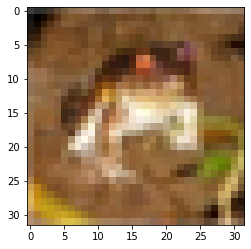

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print ('Number of samples in training set=', 
       len(X_train), '\n Pixels =', X_train.shape[1], 'x', X_train.shape[2])

plt.imshow(X_train[0])    # Plot the first sample: sanity check
plt.show()

* Class 0 = airplane,
* Class 1 = automobile,
*Class 2 = bird,
*Class 3 = cat,
*Class 4 = deer,
*Class 5 = dog,
*Class 6 = frog,
*Class 7 = horse,
*Class 8 = ship,
*Class 9 = truck

In [24]:
# STEP 1: Preprocess input data

# Convert data type to float32 and normalize to the range [0,1]
X_train_pre = X_train.astype('float32')
X_test_pre = X_test.astype('float32')
X_train_pre /= 255
X_test_pre/= 255



# STEP 2: Preprocess class labels

Y_train_pre = np_utils.to_categorical(y_train, 10)
Y_test_pre = np_utils.to_categorical(y_test, 10)
 

In [6]:

    
# STEP 3: Define model architecture

model = Sequential() 

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 
model.add(Dense(128, activation='relu')) 

# OUTPUT Dense layer: size=10, corresponding to 10 classes
model.add(Dense(10, activation='softmax'))    



# STEP 4: Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



# STEP 5: Fit model on training data
model.fit(X_train_pre, Y_train_pre, batch_size=256, epochs=10,  validation_split=0.2, verbose=1)





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [25]:
# STEP 6: Evaluate model on test data
test_loss, test_acc = model.evaluate(X_test_pre, Y_test_pre, verbose=0)
print('\n Test accuracy:', test_acc)


 Test accuracy: 0.6751000285148621


In [26]:

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [9]:
last_conv_layer_name = "max_pooling2d_1"
classifier_layer_names = ["flatten","dense","dense_1"]

In [10]:
test_img1 = X_test_pre[0].reshape(1,32,32,3)

In [11]:
predict = model.predict(test_img1)
#print(decode_predictions(predict,top=3))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

Target Class = 3


In [12]:
y_test[0]

array([3], dtype=uint8)

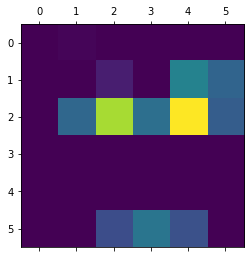

In [13]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    test_img1, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [14]:
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

In [15]:
# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

In [16]:
# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

In [17]:
 img = X_test[0]

In [19]:
# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

In [20]:
# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

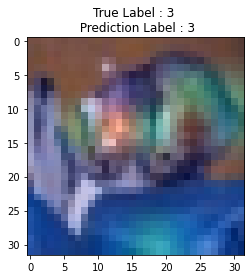

In [21]:
plt.imshow(superimposed_img)
#save_results_to = '/content/drive/MyDrive/DAI_Assignment3/'
plt.title("True Label : %d "%target_class + "\n Prediction Label : %d"%target_class)
plt.savefig(save_results_to + 'image{}.png'.format(1), dpi = 200)

In [22]:
reshape_test_img = []
predict_test_img = []
predict_label_test_img =[]
for i in range(len(X_test)):
    reshape_im = X_test_pre[i].reshape(1,32,32,3)
    predict_im = model.predict(reshape_im)
    target_class = np.argmax(predict_im[0])
    reshape_test_img.append(reshape_im)
    predict_test_img.append(predict_im)
    predict_label_test_img.append(target_class)


In [23]:
true_label_test_img = []
for i in range(len(X_test)):
    true_target_class = np.argmax(Y_test_pre[i])
    true_label_test_img.append(true_target_class)


In [27]:
correct_pred_img = []
incorrect_pred_img = []
correct_pred_label = []
incorrect_pred_label = []
correct_test_img = []
incorrect_test_img = []
correct_test_label = []
incorrect_test_label = []

for i in range(len(X_test)):
  if predict_label_test_img[i] == true_label_test_img[i] :
    reshape_im = X_test_pre[i].reshape(1,32,32,3)
    correct_test_img.append(X_test[i])
    correct_pred_img.append(reshape_im)
    correct_pred_label.append(predict_label_test_img[i])
    correct_test_label.append(true_label_test_img[i])
  else:
    reshape_im = X_test_pre[i].reshape(1,32,32,3)
    incorrect_test_img.append(X_test[i])
    incorrect_pred_img.append(reshape_im)
    incorrect_pred_label.append(predict_label_test_img[i])
    incorrect_test_label.append(true_label_test_img [i])

     

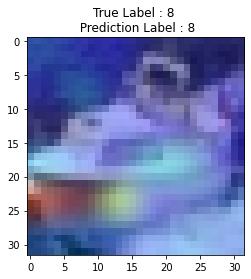

In [28]:

for i in range(1,150):
  heatmap = make_gradcam_heatmap(correct_pred_img[i], model, last_conv_layer_name, classifier_layer_names)
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")
  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  # We create an image with RGB colorized heatmap
  img = correct_test_img[i]
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  plt.imshow(superimposed_img)
  save_results_to = '/content/drive/MyDrive/DAI_Assignment3/'
  plt.title("True Label : %d "%correct_test_label[i] + "\n Prediction Label : %d"%correct_pred_label[i])
  plt.savefig(save_results_to + 'image{}.png'.format(i), dpi = 150)

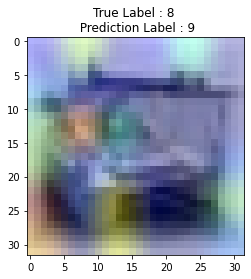

In [29]:
for i in range(1,150):
  heatmap = make_gradcam_heatmap(incorrect_pred_img[i], model, last_conv_layer_name, classifier_layer_names)
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")
  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  # We create an image with RGB colorized heatmap
  img = incorrect_test_img[i]
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  plt.imshow(superimposed_img)
  save_results_to = '/content/drive/MyDrive/DAI_Assignment3/incorrectImg'
  plt.title("True Label : %d "%incorrect_test_label[i] + "\n Prediction Label : %d"%incorrect_pred_label[i])
  plt.savefig(save_results_to + 'image{}.png'.format(i), dpi = 150)